# Retro — Figure 2

In [1]:
import json
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Load the data

In [3]:
with open('retro-db-light-v1.0.json', 'r') as f:
    db = json.load(f)
db = list(filter(lambda x: ~(x['id'] == 'ACR360') & ~(x['id'] == 'CAR1102'), db))

In [4]:
with open('overcredited_arbocs.json', 'r') as f:
    data = json.load(f)
del data['ACR360']
del data['CAR1102']

In [5]:
projects = [project 
    for project in db 
    if project['carbon']['initial_carbon_stock']['value'] > project['carbon']['common_practice']['value']
]

In [6]:
def get_summary_stats(data):
    summary_d = {}
    mod = smf.ols("cp~average_slag_baseline", data=data).fit()
    summary_d["slope"] = mod.params["average_slag_baseline"]

    delta_slag = data["average_slag_baseline"] - data["cp"]
    desc = delta_slag.describe()
    summary_d["median_delta"] = desc["50%"]
    summary_d["mean_delta"] = desc["mean"]
    return summary_d

Organize into a data frame

In [7]:
df = pd.DataFrame({
    project['opr_id']: (
        project['carbon']['average_slag_baseline']['value'], 
        project['carbon']['common_practice']['value']
    )  for project in projects}).T.rename(columns={0: 'average_slag_baseline', 1:'cp'})

In [8]:
df['recalcualted_slag'] = [np.percentile(data[key]['alt_slag'], 50) if key in data.keys() else np.NaN for key in df.index]

In [9]:
df= df.dropna()

In [10]:
df.sort_values(by=['cp'], inplace=True, ascending=False)

## Make the plot

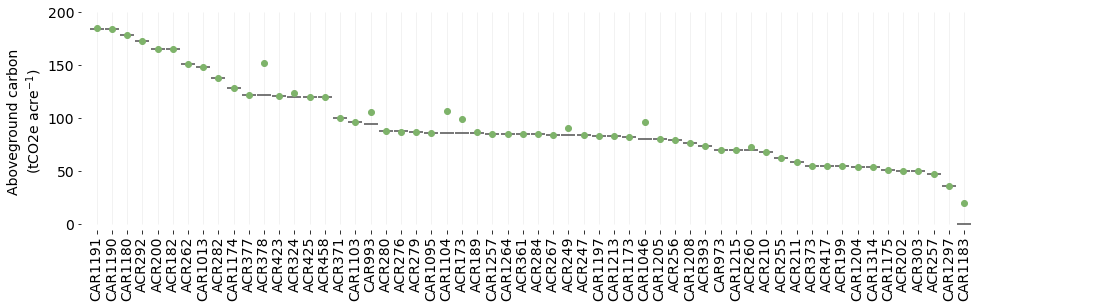

In [11]:
plt.rcParams.update({'font.size': 14, 'svg.fonttype': 'none'})

fig, ax = plt.subplots(1,1, figsize=(18,4))
ax.vlines(df.index.values, 0, 200, color=(0.95,0.95,0.95), linewidth=1)
ax.scatter(
    df.index.values, 
    df['cp'], marker='_', s=200, color='.3', lw=1.5, label='Common practice', zorder=10)
ax.plot(
    df.index.values, 
    df['average_slag_baseline'], '.', markersize=12, color='#7EB36A', label='Baseline average',  zorder=11)
ax.set_ylim(-5,200)
ax.set_xticks(df.index.values)
ax.set_xticklabels(df.index.values, rotation='vertical')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-1,65)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='major', pad=3)

ax.set_ylabel('Aboveground carbon\n(tCO2e acre$^{-1}$)')

plt.savefig('Figure-2.svg')